In [1]:
import glworia.amplification_factor
import glworia.lens_functions
from glworia.amplification_factor import *
from glworia.lens_functions import *
import glworia.lens_functions
from glworia.lens_functions import *
import glworia.contour
from glworia.contour import *
import glworia.utils
from glworia.utils import *
import glworia.root
from glworia.root import *
import glworia.plot
from glworia.plot import *

In [2]:
from importlib import reload

In [3]:
reload(glworia.amplification_factor)
reload(glworia.lens_functions)
from glworia.amplification_factor import *
from glworia.lens_functions import *
reload(glworia.lens_functions)
from glworia.lens_functions import *
reload(glworia.contour)
from glworia.contour import *
reload(glworia.utils)
from glworia.utils import *
reload(glworia.root)
from glworia.root import *
reload(glworia.plot)
from glworia.plot import *

In [4]:
from jax.config import config
config.update("jax_enable_x64", True)

In [5]:
import matplotlib.pyplot as plt

In [6]:
settings = {'newt_max_iter': 1000}
T_funcs, helper_funcs = amplification_computation_prep(Psi_NFW, **settings)
crit_curve_helper_funcs = make_crit_curve_helper_func(T_funcs)

In [8]:
Psi_1D = T_funcs['Psi_1D']
mu_vec = T_funcs['mu_vec']

In [9]:
param_arr = jnp.linspace(0.1, 10., 100000)
crit_funcs = crtical_curve_interpolants(param_arr, T_funcs, crit_curve_helper_funcs)

2023-05-18 22:38:46.521163: W external/xla/xla/service/gpu/nvptx_compiler.cc:564] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.1.105). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
N_grid = 100
kappa_low = 0.1
kappa_high = 10.0
y_low = 0.1
y_high = 5.0
kappa_arr = jnp.linspace(kappa_low, kappa_high, N_grid)
y_arr = jnp.linspace(y_low, y_high, N_grid)

In [11]:
grid_points = make_points_arr_mesh(y_arr, kappa_arr)

In [12]:
lens_param_to_y_crit = crit_funcs['lens_param_to_y_crit']
y_crit_to_lens_param = crit_funcs['y_crit_to_lens_param']
y_crit_to_x_crit = crit_funcs['y_crit_to_x_crit']

@partial(jnp.vectorize, signature = '(n,2)->(n)')
def is_strong(point):
    return lens_param_to_y_crit(point[:,1]) > point[:,0]

In [13]:
weak_points = grid_points[~is_strong(grid_points)]
strong_points = grid_points[is_strong(grid_points)]

In [14]:
kappa_crit_points = jnp.linspace(kappa_low, kappa_high, num = N_grid**2)
x_crit_points, y_crit_points = get_crit_curve_1D(kappa_crit_points, T_funcs, crit_curve_helper_funcs, x_hi = 100.)

In [15]:
crit_points = jnp.vstack([y_crit_points, kappa_crit_points]).T

In [16]:
boundary_crit_points = jnp.array([[y_arr[0], y_crit_to_lens_param(y_arr[0])],
                                  [y_arr[-1], y_crit_to_lens_param(y_arr[-1])]])
boundary_crit_points = boundary_crit_points[~jnp.isnan(boundary_crit_points).any(axis = 1)]

In [17]:
crit_points_all = jnp.vstack([boundary_crit_points, crit_points])
y_crit_points_all = jnp.append((boundary_crit_points[:,0]), y_crit_points)
x_crit_points_all = jnp.append((y_crit_to_x_crit(boundary_crit_points[:,0])), -x_crit_points)
kappa_crit_points_all = jnp.append((boundary_crit_points[:,1]), kappa_crit_points)

in_bound = crit_points_all[:, 0] >= 0.1

crit_points_in_bound = crit_points_all[in_bound]
y_crit_points_in_bound = y_crit_points_all[in_bound]
x_crit_points_in_bound = x_crit_points_all[in_bound]
kappa_crit_points_in_bound = kappa_crit_points_all[in_bound]

In [18]:
from scipy.interpolate import LinearNDInterpolator

In [19]:
crit_bisect_x_low = -10
crit_bisect_x_high = 10
crit_bisect_x_num = 100
crit_x_init_arr = jnp.linspace(
    crit_bisect_x_low, 
    crit_bisect_x_high, 
    crit_bisect_x_num)

crit_screen_round_decimal = 8

newt_cond_fun = helper_funcs['newt_cond_fun']
newt_step_fun = helper_funcs['newt_step_fun']

get_crit_points_1D_vec = jnp.vectorize(
    get_crit_points_1D, 
    excluded = {0, 1, 2, 5},
    signature = '(),()->(3)')
get_crit_points_2D_arr = lambda x: get_crit_points_1D_vec(
    crit_x_init_arr, 
    newt_cond_fun, 
    newt_step_fun,  
    x[:, 0], x[:, 1], 
    crit_screen_round_decimal)

In [20]:
strong_image_x = get_crit_points_2D_arr(strong_points)
strong_sad_x, strong_max_x, strong_min_x = jnp.hsplit(strong_image_x, strong_image_x.shape[1])

In [21]:
weak_image_x = get_crit_points_2D_arr(weak_points)
weak_sad_x, weak_max_x, weak_min_x = jnp.hsplit(weak_image_x, weak_image_x.shape[1])

In [22]:
crit_image_x_newt = get_crit_points_2D_arr(crit_points_in_bound)
crit_sad_x, crit_max_x, crit_min_x = jnp.hsplit(crit_image_x_newt, crit_image_x_newt.shape[1])

In [23]:
crit_image_x = jnp.vstack([x_crit_points_in_bound, x_crit_points_in_bound, crit_min_x.ravel()]).T

In [24]:
crit_sad_x, crit_max_x, crit_min_x = jnp.hsplit(crit_image_x, crit_image_x.shape[1])

In [25]:
@partial(jnp.vectorize, excluded = {3}, signature = '(),(),()->()')
@partial(jit, static_argnums = (3))
def T_1D_vec(x, y, lens_params, Psi_1D):
    lens_params = jnp.atleast_1d(lens_params)
    return jnp.linalg.norm(x - y)**2/2 - Psi_1D(x, lens_params)

In [26]:
strong_points_full = jnp.vstack([strong_points, crit_points_in_bound])

In [27]:
strong_full_sad_x = jnp.concatenate([strong_sad_x, crit_sad_x]).T[0]
strong_full_max_x = jnp.concatenate([strong_max_x, crit_max_x]).T[0]
strong_full_min_x = jnp.concatenate([strong_min_x, crit_min_x]).T[0]

In [28]:
strong_full_sad_T = T_1D_vec(strong_full_sad_x, strong_points_full[:,0], strong_points_full[:,1], Psi_1D)
strong_full_max_T = T_1D_vec(strong_full_max_x, strong_points_full[:,0], strong_points_full[:,1], Psi_1D)
strong_full_min_T = T_1D_vec(strong_full_min_x, strong_points_full[:,0], strong_points_full[:,1], Psi_1D)

In [29]:
interp_strong_full_sad_T_adj = LinearNDInterpolator(strong_points_full, strong_full_sad_T - strong_full_min_T)
interp_strong_full_max_T_adj = LinearNDInterpolator(strong_points_full, strong_full_max_T - strong_full_min_T)

In [30]:
import pickle
import os

interp_name = f'NFW_y_{y_low:.3f}_{y_high:.3f}_kappa_{kappa_low:.3f}_{kappa_high:.3f}_N_{N_grid}'
os.makedirs(f'./interpolation/{interp_name}', exist_ok = True)

with open(f'./interpolation/{interp_name}/strong_full_sad_T_adj.pkl', 'wb') as f:
    pickle.dump(interp_strong_full_sad_T_adj, f)

with open(f'./interpolation/{interp_name}/strong_full_max_T_adj.pkl', 'wb') as f:
    pickle.dump(interp_strong_full_max_T_adj, f)

In [37]:
strong_full_sad_mu = jnp.abs(mu_vec(strong_full_sad_x, strong_points_full[:,1]))
strong_full_max_mu = jnp.abs(mu_vec(strong_full_max_x, strong_points_full[:,1]))
strong_full_min_mu = jnp.abs(mu_vec(strong_full_min_x, strong_points_full[:,1]))

In [40]:
interp_strong_full_sad_mu = LinearNDInterpolator(strong_points_full, strong_full_sad_mu)
interp_strong_full_max_mu = LinearNDInterpolator(strong_points_full, strong_full_max_mu)
interp_strong_full_min_mu = LinearNDInterpolator(strong_points_full, strong_full_min_mu)

In [41]:
with open(f'./interpolation/{interp_name}/strong_full_sad_mu.pkl', 'wb') as f:
    pickle.dump(interp_strong_full_sad_mu, f)

with open(f'./interpolation/{interp_name}/strong_full_max_mu.pkl', 'wb') as f:
    pickle.dump(interp_strong_full_max_mu, f)

with open(f'./interpolation/{interp_name}/strong_full_min_mu.pkl', 'wb') as f:
    pickle.dump(interp_strong_full_min_mu, f)

In [31]:
y_interp = jnp.linspace(0.1, 5.0, 234)
kappa_interp = jnp.linspace(0.1, 10.0, 234)

y_interp_mesh, kappa_interp_mesh = jnp.meshgrid(y_interp, kappa_interp)
T_interp_sad = interp_strong_full_sad_T_adj(y_interp_mesh, kappa_interp_mesh)
T_interp_max = interp_strong_full_max_T_adj(y_interp_mesh, kappa_interp_mesh)

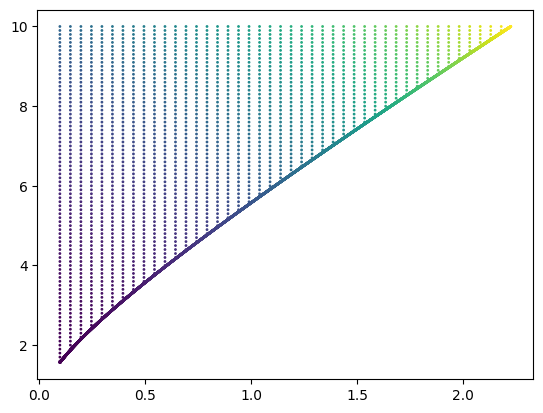

In [32]:
plt.scatter(strong_points_full[:,0], strong_points_full[:,1], c = strong_full_max_T - strong_full_min_T, s = 1)

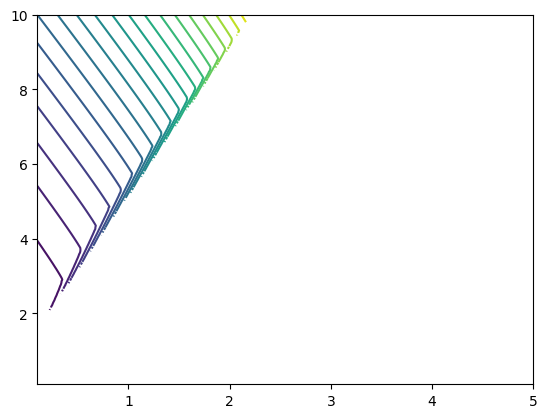

In [33]:
plt.contour(y_interp, kappa_interp, T_interp_max, 20)

In [156]:
reload(glworia.amplification_factor)
reload(glworia.lens_functions)
from glworia.amplification_factor import *
from glworia.lens_functions import *
reload(glworia.lens_functions)
from glworia.lens_functions import *
reload(glworia.contour)
from glworia.contour import *
reload(glworia.utils)
from glworia.utils import *
reload(glworia.root)
from glworia.root import *
reload(glworia.plot)
from glworia.plot import *